# Clustering bank customers
#### C. Griffith - BUSI 650 Summer 2022

##### **Objective** 

> To create optimal number of clusters for the bank customers, describe how each cluster differs from others, and suggest business insights for the bank

### ***Import packages and define functions.***

In [ ]:
# Start writing code here...# import packages
from google.colab import drive
import copy

# Library to suppress warnings or deprecation notes
import warnings

# To perform statistical analysis
# to compute distances
from scipy.spatial.distance import cdist
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from math import log2, sqrt
import datetime

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm

# To build models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn import tree

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Library to split data
from sklearn.model_selection import train_test_split

# for plotting calibration curve using true and predicted labels.
from sklearn.calibration import CalibrationDisplay

# To tune different models
# https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

# To get diferent metric scores
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, roc_auc_score,
    PrecisionRecallDisplay, average_precision_score, auc, f1_score, recall_score, precision_score,
    plot_confusion_matrix, make_scorer, silhouette_score
)

# matplotlib graphs will be included in notebook, next to the code
%matplotlib inline 

# format for seaborn plots
sns.set(color_codes=True)
sns.set(style="darkgrid")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
# function to plot stacked bar chart.
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    #tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    #print(tab1)
    #print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# function to create box plot and histplot on same axis
def HistBoxPlot(dataframe, feature, hue = None, cum = False, bins = 'auto'):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = (9,7)) 
                                          
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow'); # A star will indicate the mean value of the column
    sns.histplot(data=dataframe, x=feature, kde=True, hue=hue, bins=bins, cumulative = cum, ax=ax_hist2); # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='-'); # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-'); # Add median to the histogram

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification(model, predictors, target):

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

def make_confusion_matrix(model, predictors, target):

    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")

### ***Read the dataset into pandas dataframes.***

In [ ]:
# Authorization of GDrive
drive.mount('/content/drive/')

# Change working directory location to datasets
%cd /content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets


In [ ]:
%ls 

AOVData.csv                          Loan_Delinquent_Dataset.csv
assignment.csv                       movie.csv
Automobile.csv                       mtcars.csv
auto-mpg.csv                         NEP.csv
Beverage.csv                         OfficeSupplies.csv
bookseller.csv                       Pima_Indians.csv
boston.csv                           ratings.csv
debugging.csv                        sat_score.csv
diet.csv                             SATVerbal1.csv
doses.csv                            TitanInsurance.csv
Engineering_Colleges_Case_Study.csv  ToyotaCorolla.csv
FastFood1.csv                        TVRadio.csv
Florida.csv                          UniversalBank.csv
German_Credit.csv                    user.csv
honeyproduction1998-2016.csv         Walmart_Features_data_set.csv
InternetMobileTime.csv               Walmart_sales_data_set.csv
iris.csv                             Walmart_stores_data_set.csv
Loan_Customers.csv                   working_adults.csv


In [ ]:
# Load dataset
df = pd.read_csv('Loan_Customers.csv')

### ***Explore***
* Examined the data set and carried out EDA 

**Data is available about 381 customers who had applied for a loan. It has 13 attributes as below:**
* 'Loan_ID', 		ID of the customer loan application
* 'Gender', 		Gender of the customer
* 'Married',		Marital Status of customer
* 'Dependents', 	Number of dependents
* 'Education',		Graduate or not
* 'Self_Employed',	Whether self-employed
* 'ApplicantIncome', 	Income of applicant per 1,000
* 'CoapplicantIncome',	Income of coapplicant per 1,000
* 'LoanAmount',	Amount of loan applied in $1k
* 'Loan_Amount_Term',	Duration of loan in months
* 'Credit_History', 	Credit history (1: yes, 0: no)
* 'Property_Area', 	Type of property
* 'Loan_Status'	Whether loan was given (Y: yes, N: No)


#### ***Initial Review***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [ ]:
# drop unneed column
df = df.drop(columns=['Loan_ID'])

In [ ]:
# Convert Data Types
df.Credit_History.replace({1: 'Y', 0: 'N'}, inplace=True)
df.Credit_History = df.Credit_History.astype('object') 
for column in df.columns.values:
  if df[column].dtypes == 'object':
    df[column] = df[column].astype('category')

In [ ]:
# show number of null values in each column
df.isnull().sum()

Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
# remove rows with NAs
df.dropna(inplace=True)

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,308,2,Male,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,308,2,Yes,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,308,4,0,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,308,2,Graduate,229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,308,2,No,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,308.0,NaN,NaN,NaN,3599.126623,1462.359612,150.0,2568.75,3329.5,4291.0,9703.0
CoapplicantIncome,308.0,NaN,NaN,NaN,1278.434805,2520.961308,0.0,0.0,871.5,1953.5,33837.0
LoanAmount,308.0,NaN,NaN,NaN,104.623377,29.382256,9.0,89.75,110.0,128.0,150.0
Loan_Amount_Term,308.0,NaN,NaN,NaN,341.181818,68.246006,36.0,360.0,360.0,360.0,480.0
Credit_History,308,2,Y,263,NaN,NaN,NaN,NaN,NaN,NaN,NaN



**Observation**

> There are 381 records, 11 features and one target variable. Six out of eleven features are categorical. Loan_Amount_Term could possible be categorical variable


---



### ***Univariate analysis***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 380
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             308 non-null    category
 1   Married            308 non-null    category
 2   Dependents         308 non-null    category
 3   Education          308 non-null    category
 4   Self_Employed      308 non-null    category
 5   ApplicantIncome    308 non-null    int64   
 6   CoapplicantIncome  308 non-null    float64 
 7   LoanAmount         308 non-null    float64 
 8   Loan_Amount_Term   308 non-null    float64 
 9   Credit_History     308 non-null    category
 10  Property_Area      308 non-null    category
 11  Loan_Status        308 non-null    category
dtypes: category(8), float64(3), int64(1)
memory usage: 15.5 KB


#### ***Categorical***

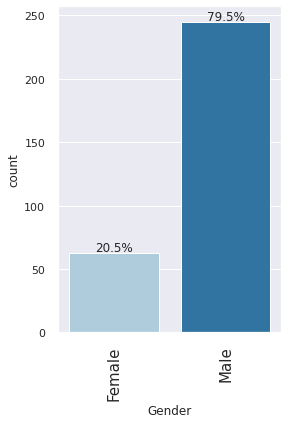

In [ ]:
labeled_barplot(df, "Gender", perc=True)

**Observation**
> Majority of the customers are male.

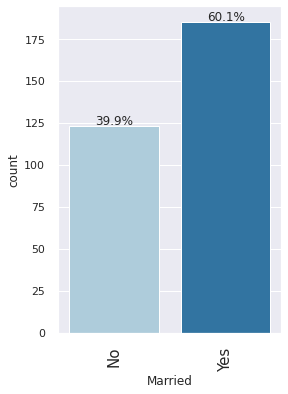

In [ ]:
labeled_barplot(df, "Married", perc=True)

**Observation**
> Majority of the customers are married.

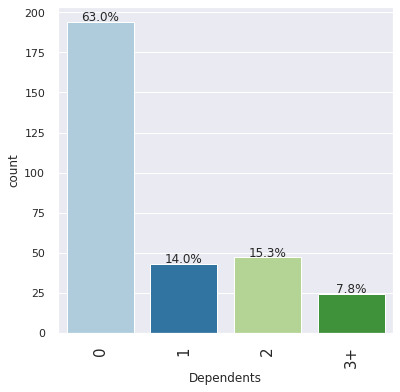

In [ ]:
labeled_barplot(df, "Dependents", perc=True)

**Observation**
> Majority of the customers do not have children.

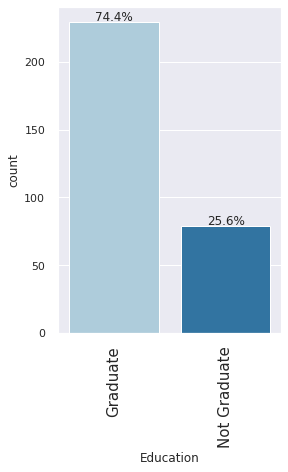

In [ ]:
labeled_barplot(df, "Education", perc=True)

**Observation**
> Majority of the customers graduated from college.

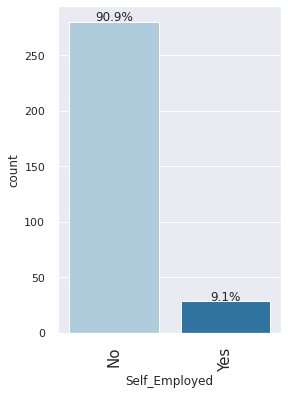

In [ ]:
labeled_barplot(df, "Self_Employed", perc=True)

**Observation**
> Majority of the customers are not self-employed.

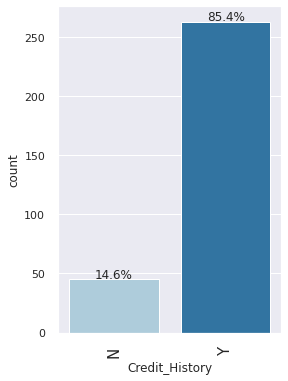

In [ ]:
labeled_barplot(df, "Credit_History", perc=True)

**Observation**
> Majority of the customers have a credit history.

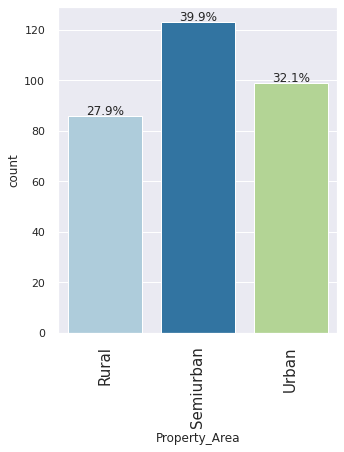

In [ ]:
labeled_barplot(df, "Property_Area", perc=True)

**Observation**
> Majority of the customers live in a semiurban/suburban area.

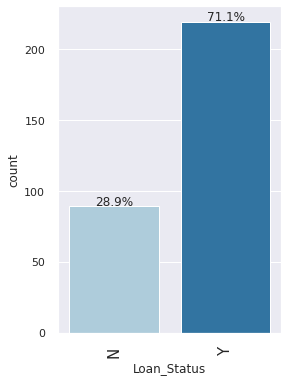

In [ ]:
labeled_barplot(df, "Loan_Status", perc=True)

**Observation**
> Majority of the customers received a loan from the bank.

#### ***Continuous***

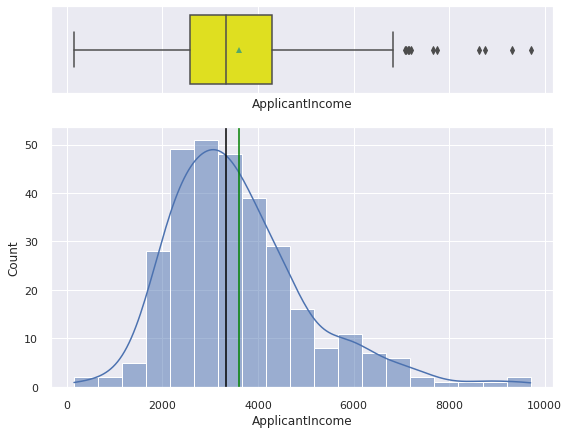

In [ ]:
HistBoxPlot(df, df.ApplicantIncome);

In [ ]:
# number of unique applicant income
df.ApplicantIncome.nunique()

267


**Observation**

> The median applicant income is around 3500 while the mean is just above the median. The distribution appears to be gaussian but slightly skewed to the right. There are a few outliers accounting for higher income applicants.


---

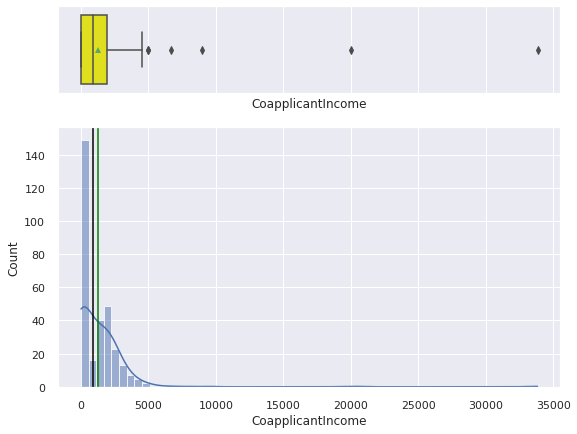

In [ ]:
HistBoxPlot(df, df.CoapplicantIncome, bins=60);

In [ ]:
# number of unique coapplicant income
df.CoapplicantIncome.nunique()

153

**Observation**

> Majority of the coapplicant incomes apppear to be low. There are quite of a few coapplicants with very high income.


---

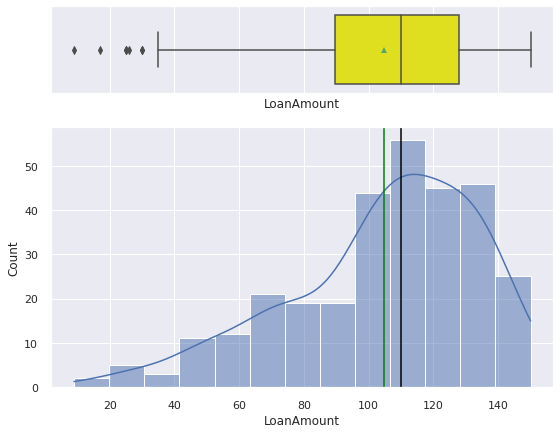

In [ ]:
HistBoxPlot(df, df.LoanAmount);

In [ ]:
# number of unique requested loan amounts
df.LoanAmount.nunique()

96

**Observation**

> Majority of the loan amounts appear to be skewed to the left.


---

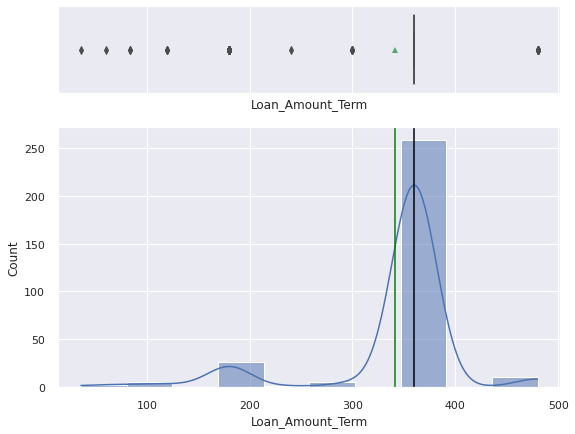

In [ ]:
HistBoxPlot(df, df.Loan_Amount_Term);

In [ ]:
# number of unique requested loan terms
df.Loan_Amount_Term.nunique()

9

**Observation**

> As expected, the loan amount term variable is discrete and should be treated as a categorical variable.


---

In [ ]:
# convert to categorical
df.Loan_Amount_Term = df.Loan_Amount_Term.astype('category')

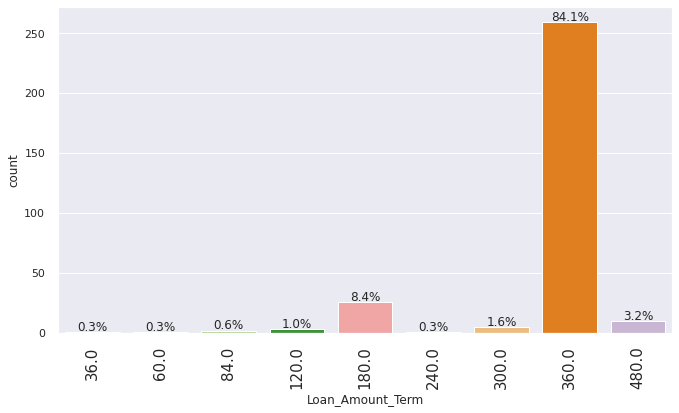

In [ ]:
labeled_barplot(df, "Loan_Amount_Term", perc=True)

**Observation**

> Majority of the requested loan tems are 360 months or 30 year loans. This could be referring to mortgages.


---

### ***Bivariate Analysis***

In [ ]:
# extract only the numerical variables
num_col = df.select_dtypes(include=np.number).columns.tolist()
num_col

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [ ]:
# remove the loan term variable from the list
num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

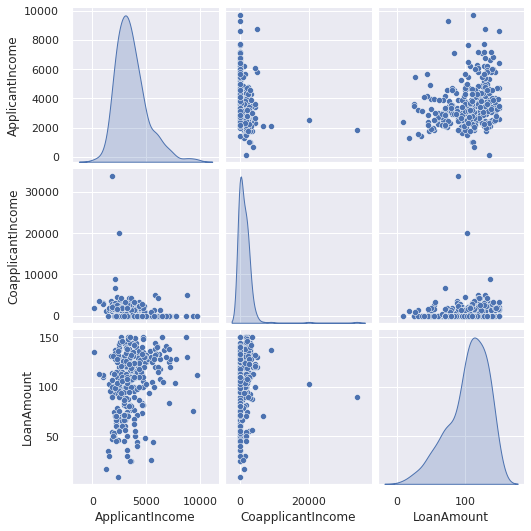

In [ ]:
# plot the pairplot between the numerical variables
sns.pairplot(data=df[num_col], diag_kind="kde");

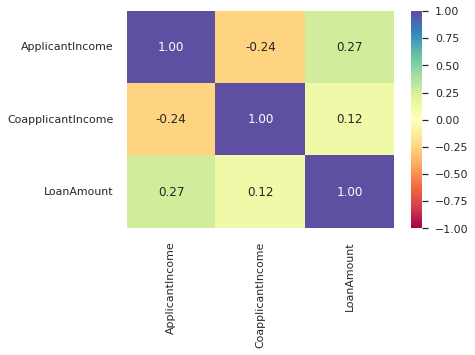

In [ ]:
# plot the correlation matrix of the numerical variables
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");

**Observation**

> There appears to be a positive correlation between applicant income and loan amount as well as coapplicant income and loan amount. There is a negative correlation between applicant income and coapplicant income.


---

### ***Data Preparation***

In [ ]:
# numerical features
num_col

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [ ]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

### ***Model Building***

Number of Clusters: 1 	Average Distortion: 1.3955745897708491
Number of Clusters: 2 	Average Distortion: 1.1368440841128762
Number of Clusters: 3 	Average Distortion: 1.0792981022530264
Number of Clusters: 4 	Average Distortion: 0.8804237504273313
Number of Clusters: 5 	Average Distortion: 0.7833538877656404
Number of Clusters: 6 	Average Distortion: 0.7021773400679622
Number of Clusters: 7 	Average Distortion: 0.6632048384286664
Number of Clusters: 8 	Average Distortion: 0.6351196431903364
Number of Clusters: 9 	Average Distortion: 0.6160287229181107




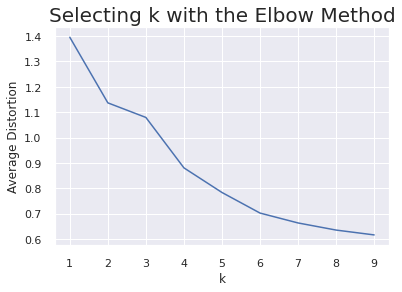

In [ ]:
# create distortion plot of 1 - 9 clusters
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

print('\n')
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20);

**Observation**
> The appropriate value of k from the elbow curve seems to be 4, 5 or 6.




For n_clusters = 2, silhouette score is 0.30322754750373876
For n_clusters = 3, silhouette score is 0.3288238598679857
For n_clusters = 4, silhouette score is 0.37529967874336523
For n_clusters = 5, silhouette score is 0.34049388291574234
For n_clusters = 6, silhouette score is 0.33924464340313276
For n_clusters = 7, silhouette score is 0.3120625600273273
For n_clusters = 8, silhouette score is 0.30564547943087905
For n_clusters = 9, silhouette score is 0.3179951552672916


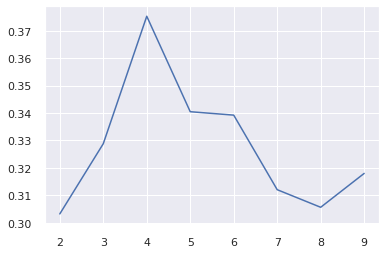

In [ ]:
# create silhouette score from 2 - 9 clusters
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score);

**Observation**
> 4 or 5 clusters are good candidates.



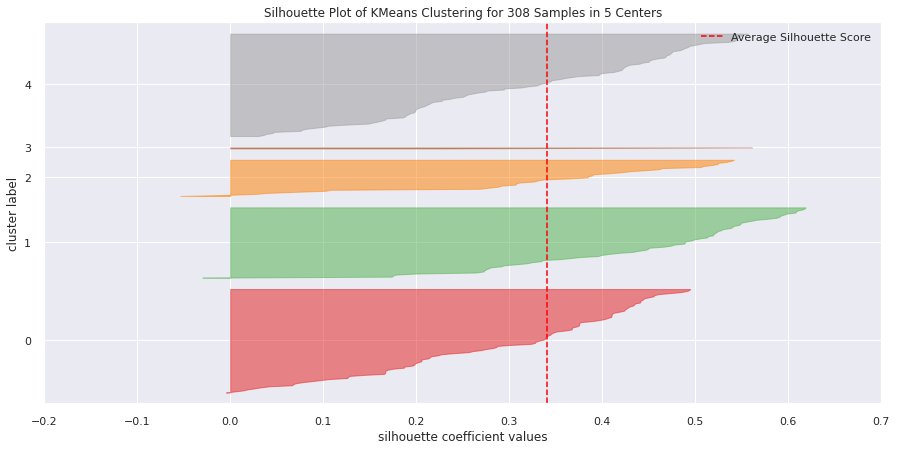

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15, 7))
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show();

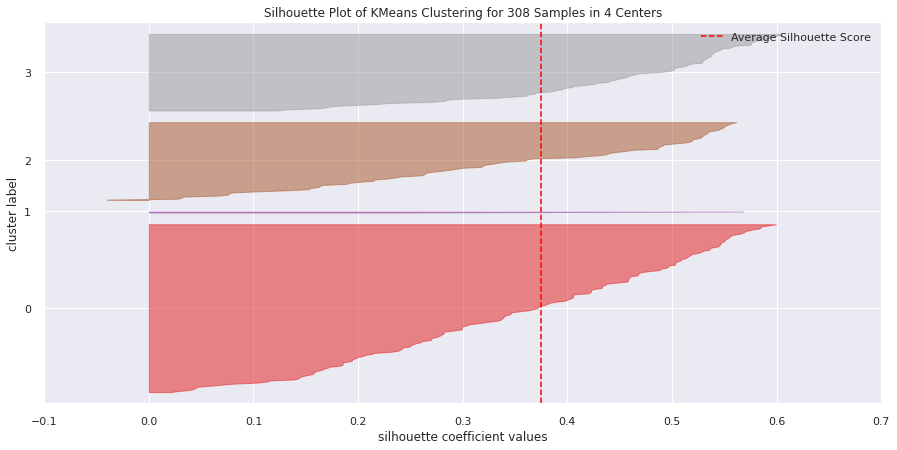

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15, 7))
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show();

**Observation**

> Based on elbow method and silhouette analysis, we will commit to 4 clusters.



### ***Review***

In [ ]:
# use 4 clusters based on elbow method and silhouette analysis
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

# print how many customers in each cluster
cluster_num = list(df['K_means_segments'].unique())
cluster_num.sort()

for cluster in cluster_num:
  print("Cluster {}: {} Customers".format(cluster, len(df[df.K_means_segments == cluster])))

Cluster 0: 74 Customers
Cluster 1: 2 Customers
Cluster 2: 159 Customers
Cluster 3: 73 Customers


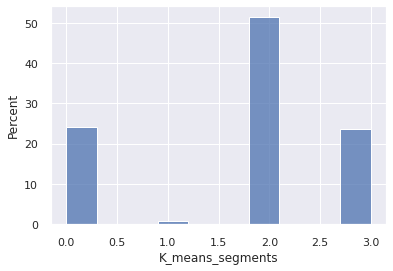

In [ ]:
# show distribution of clusters
sns.histplot(data=df, x="K_means_segments", stat="percent");

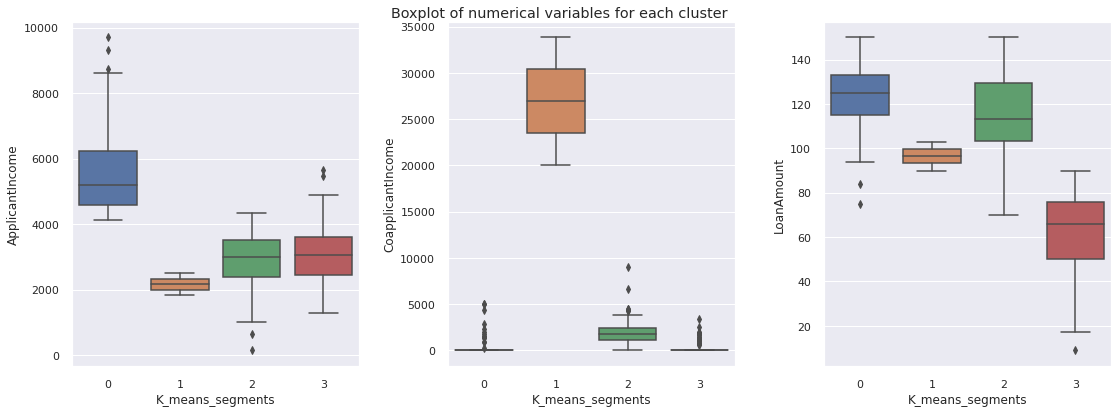

In [ ]:
# plot boxplot of numerical variables for each cluster
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(3):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

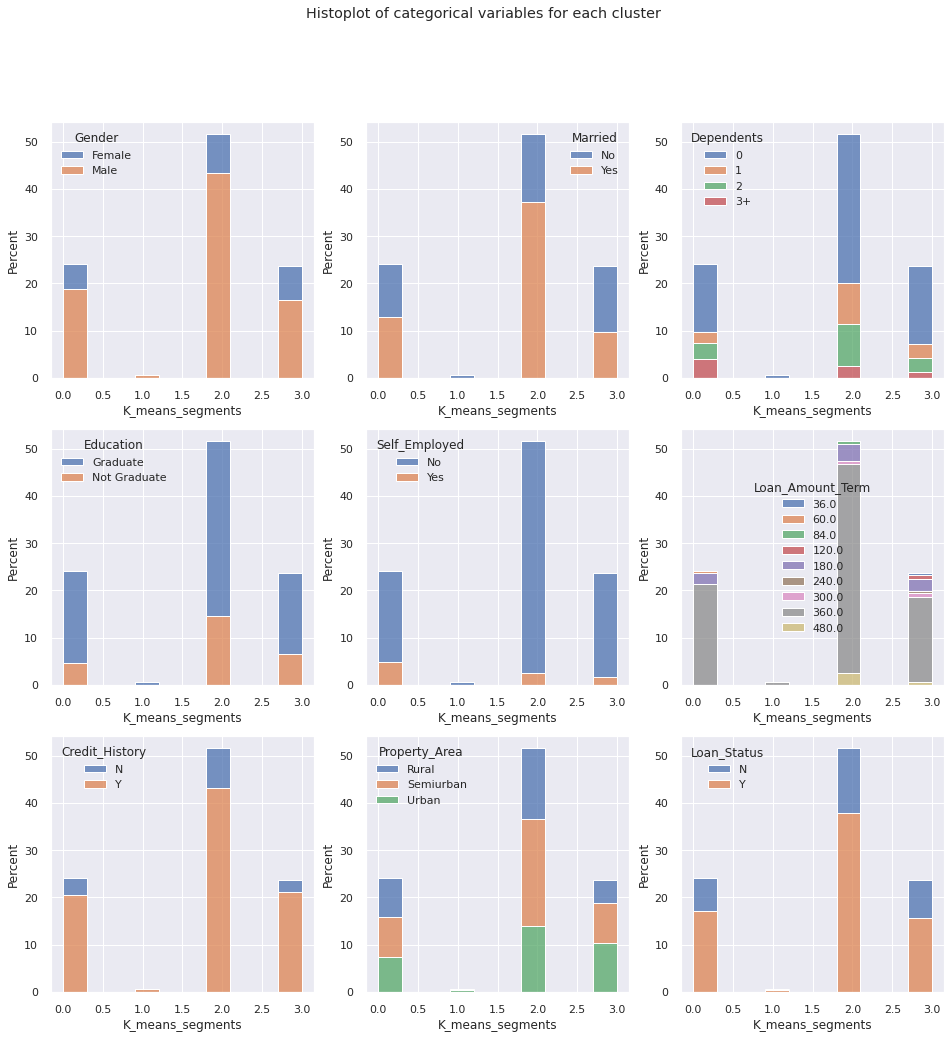

In [ ]:
# plot histplot of categorical variables for each cluster

cat_col = ['Gender','Married','Dependents','Education','Self_Employed',
           'Loan_Amount_Term','Credit_History','Property_Area','Loan_Status']
           
fig, axes = plt.subplots(3, 3, figsize=(16 , 16))
fig.suptitle("Histoplot of categorical variables for each cluster")
counter = 0
for i in range(3):
  for j in range(3):
    sns.histplot(ax=axes[i,j], data=df, x="K_means_segments", stat="percent", hue=cat_col[counter], multiple="stack");
    counter = counter + 1

In [ ]:
#create profile for numerical variables
cluster_profile_1 = df.groupby("K_means_segments")[num_col].mean()

In [ ]:
# create dummy variables of categorical variables to take sum
df_w_dummies = df.drop(columns=num_col)
df_w_dummies = pd.get_dummies(df_w_dummies)

#create profile for categorical variables
cluster_profile_2 = df_w_dummies.groupby("K_means_segments").sum()

In [ ]:
# merge profiles
complete_profile = pd.concat([cluster_profile_1, cluster_profile_2], axis=1)

In [ ]:
# create column for cluster count
complete_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["ApplicantIncome"].count().values
)

In [ ]:
# let's display cluster profiles
results = round(complete_profile.T, 2)
results.style.highlight_max(color="lightgreen", axis=1)

K_means_segments,0,1,2,3
ApplicantIncome,5569.990000,2168.000000,2922.400000,3114.440000
CoapplicantIncome,416.950000,26918.500000,1776.230000,365.010000
LoanAmount,122.860000,96.500000,115.970000,61.640000
Gender_Female,16.000000,0.000000,25.000000,22.000000
Gender_Male,58.000000,2.000000,134.000000,51.000000
Married_No,34.000000,2.000000,44.000000,43.000000
Married_Yes,40.000000,0.000000,115.000000,30.000000
Dependents_0,44.000000,2.000000,97.000000,51.000000
Dependents_1,7.000000,0.000000,27.000000,9.000000
Dependents_2,11.000000,0.000000,27.000000,9.000000


### ***Insights***

**Cluster 0**: *74 Applicants or Customers*
*   High Average Income
*   Low Average Coapplicant Income
*   High Average Requested Loan Amounts
*   Mostly apply for 360 months term loans
*   High Self-Employed Population
*   Highest 3+ Dependent Population
*   Mostly married
> *Business Recommendation:* **These applicants have high income and most likely either own a business or have high paying jobs. Since these applicants are very likely to be married to a spouse with low income and with many dependents or children, the loans requested by these customers could be related to a house purchase.**

---

**Cluster 1**: *2 Applicants or Customers*
*   Low Average Income
*   Very High Average Coapplicant Income
*   Medium Average Requested Loan Amounts
*   All apply for 360 months term loans
*   All not married
> *Business Recommendation:* **These applicants have the lowest income and are not married. Their coapplicants tend to have very high income which may suggest this customer is very young or a post-college student with a cosigner is may be a parent. The loan requested may be related to a car purchase or condominium due to the medium average loan amount.**

---

**Cluster 2**: *159 Applicants or Customers*
*   Medium Average Income
*   Medium Average Coapplicant Income
*   High Average Requested Loan Amounts
*   Various different term loans but highest is 360 months
*   Largest Employed Population
*   Mostly married
*   Mostly in Suburban areas
> *Business Recommendation:* **These applicants have medium income and have medium paying jobs. Since these applicants are very likely to be married to a spouse with also medium income, the loans requested by these customers could be related to a house or family car purchase.**
---

**Cluster 3**: *73 Applicants or Customers*

*   Medium Average Income
*   Low Average Coapplicant Income
*   Low Average Requested Loan Amounts
*   Various different term loans but highest is 360 months
*   Mostly not married
*   Mostly in Urban areas
> *Business Recommendation:* **These applicants have medium income and have medium paying jobs. Their coapplicants tend to have low income. They are mostly not married and live in an urban area. The loan requested may be related to a possibly starting a business, repairs or they are seeking funds to pay off other debts.**
